# Conditional GAN -MNIST Augmentation

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import trange

## Utilities

In [2]:
def plot_results(images, n_cols=None, title=None):
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    fig = plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
    plt.suptitle(title)

In [3]:
BATCH_SIZE = 128
CODINGS_SIZE = 32
N_EPOCHS = 150
D_STEPS = 5
GP_WEIGHT = 10.0

N_CHANNELS = 1
N_CLASSES = 10
IM_SIZE = 28

G_INP_CHANNELS = CODINGS_SIZE + N_CLASSES
D_INP_CHANNELS = N_CHANNELS + N_CLASSES

# Prepare the Dataset

In [4]:
def prepare_data(batch_size):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    y_all = keras.utils.to_categorical(y_all, 10)

    dataset = tf.data.Dataset.from_tensor_slices((X_all, y_all))
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    return dataset

def prepare_images(label):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]
    
    return X_train

# Build the Model

Generative Adversarial Networks (GANs) let us generate novel image data, video data, or audio data from a random input. Typically, the random input is sampled from a normal distribution, before going through a series of transformations that turn it into something plausible (image, video, audio, etc.).

However, a simple DCGAN doesn't let us control the appearance (e.g. class) of the samples we're generating. For instance, with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us choose the class of digits we're generating. To be able to control what we generate, we need to condition the GAN output on a semantic input, such as the class of an image.

### Generator

For the generator, we take in random noise and eventually transform it to the shape of the MNIST images. The general steps are:

* Feed the input noise to a dense layer.
* Reshape the output to have three dimensions. This stands for the (length, width, number of filters).
* Perform a deconvolution (with Conv2DTranspose), reducing the number of filters by half and using a stride of `2`.
* The final layer upsamples the features to the size of the training images. In this case 28 x 28 x 1.

Notice that batch normalization is performed except for the final deconvolution layer. As best practice, `selu` is the activation used for the intermediate deconvolution while `tanh` is for the output.

### Discriminator

The discriminator will use strided convolutions to reduce the dimensionality of the input images. As best practice, these are activated by LeakyRELU. The output features will be flattened and fed to a 1-unit dense layer without any activation.

In [5]:
def build_generator():
    inputs = keras.Input(shape=[G_INP_CHANNELS])
    x = keras.layers.Dense(7 * 7 * 128)(inputs)
    x = keras.layers.Reshape([7, 7, 128])(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    skip = keras.layers.BatchNormalization()(skip)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(skip)
    skip = keras.layers.BatchNormalization()(skip)
    x = keras.layers.add([x, skip])
    x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME",activation="selu")(x)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    skip = keras.layers.BatchNormalization()(skip)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(skip)
    skip = keras.layers.BatchNormalization()(skip)
    x = keras.layers.add([x, skip])
    outputs = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME",activation="tanh")(x)
    return keras.models.Model(inputs, outputs, name='generator')

In [6]:
def build_discriminator():
    return keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, D_INP_CHANNELS]),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
], name='discriminator')

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data
        image_size = real_images.shape[1]
        num_classes = one_hot_labels.shape[-1]
        
        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss} 

Generator Summary


Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         269696      input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 128)    0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 128)    512         reshape[0][0]                    
______________________________________________________________________

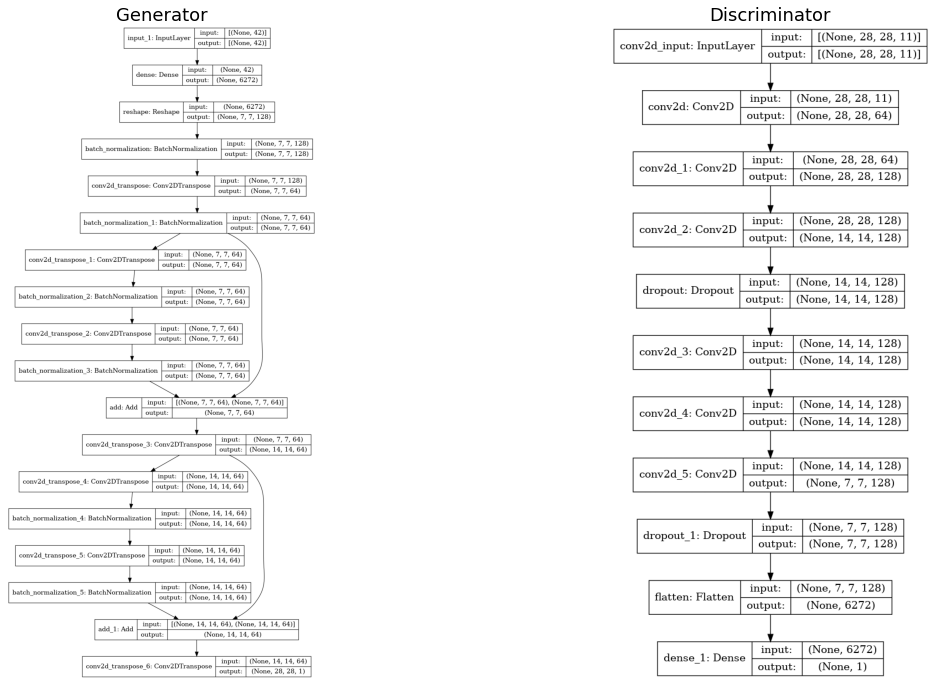

In [8]:
generator = build_generator()
discriminator = build_discriminator()
print('Generator Summary\n\n')
generator.summary()
print('\n\nDiscriminator Summary\n\n')
discriminator.summary()
keras.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='generator.png')
keras.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='discriminator.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(plt.imread('generator.png'))
ax[0].set_title('Generator', fontsize=18)
ax[1].imshow(plt.imread('discriminator.png'))
ax[1].set_title('Discriminator', fontsize=18)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# GAN in Action

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/150
546/546 [==============================] - 41s 60ms/step - d_loss: 0.0289 - g_loss: 9.6885
Epoch 2/150
546/546 [==============================] - 33s 60ms/step - d_loss: 3.8600e-05 - g_loss: 12.2485
Epoch 3/150
546/546 [==============================] - 33s 60ms/step - d_loss: 9.2031e-06 - g_loss: 13.1627
Epoch 4/150
546/546 [==============================] - 33s 60ms/step - d_loss: 0.0122 - g_loss: 13.5490
Epoch 5/150
546/546 [==============================] - 33s 60ms/step - d_loss: 0.0349 - g_loss: 11.1130
Epoch 6/150
546/546 [==============================] - 33s 60ms/step - d_loss: 0.0760 - g_loss: 8.3095
Epoch 7/150
546/546 [==============================] - 33s 60ms/step - d_loss: 0.2697 - g_loss: 2.9118
Epoch 8/150
546/546 [==============================] - 33s 60ms/step - d_loss: 0.2638 - g_loss: 2.9027
Epoch 9/150
546/546 [==============================] - 33s 60ms/step - d_loss: 0.3297 - g_loss: 2.4

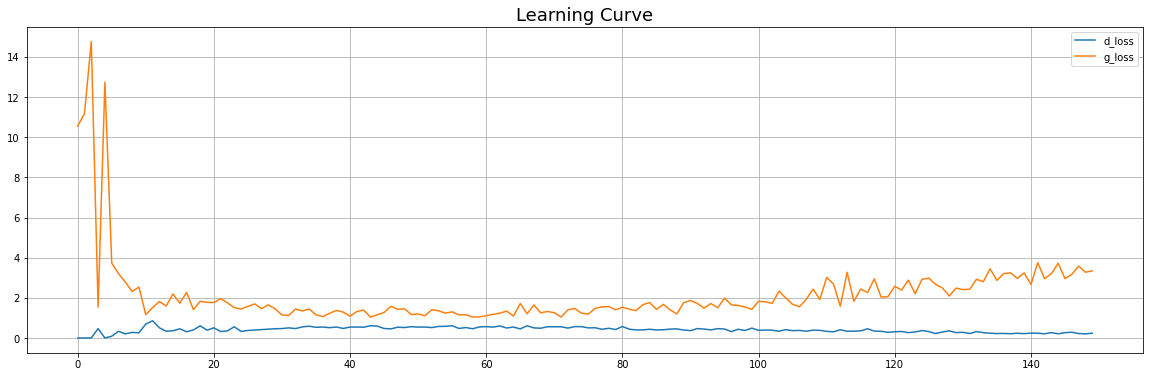

In [9]:
dataset = prepare_data(BATCH_SIZE)

gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, 
    latent_dim=CODINGS_SIZE
)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
)

history = gan.fit(dataset, epochs=N_EPOCHS, verbose=1)

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title(f'Learning Curve', fontsize=18)
pd.DataFrame(history.history).plot(ax=ax)
ax.grid()

generator.save(f'MNIST-AUG-ConditionalGAN.h5')

# Generated Images

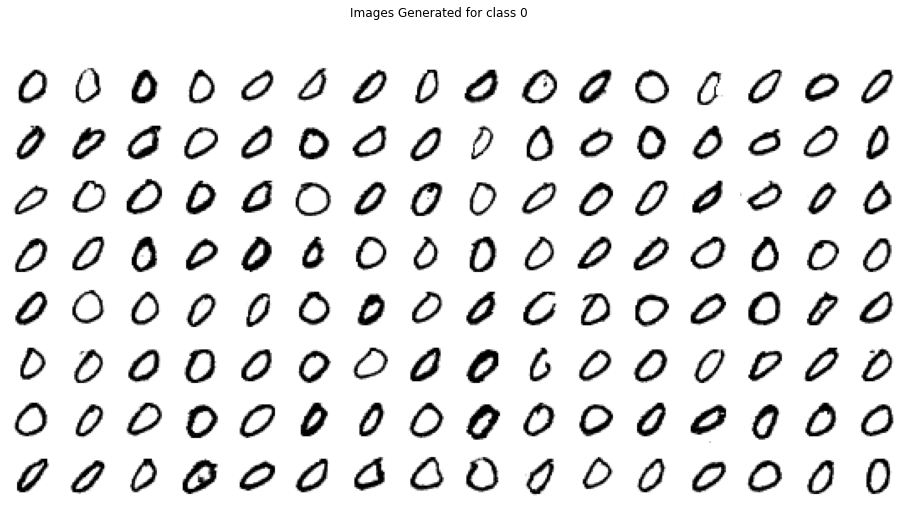

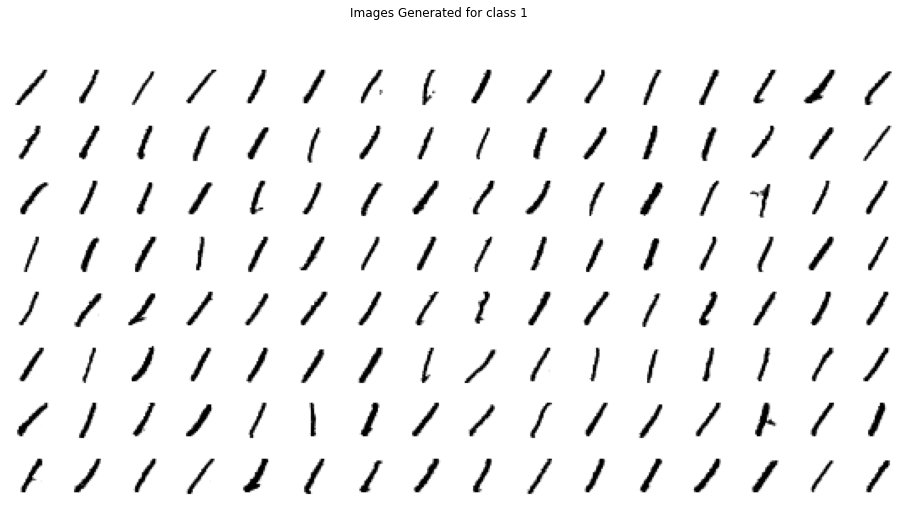

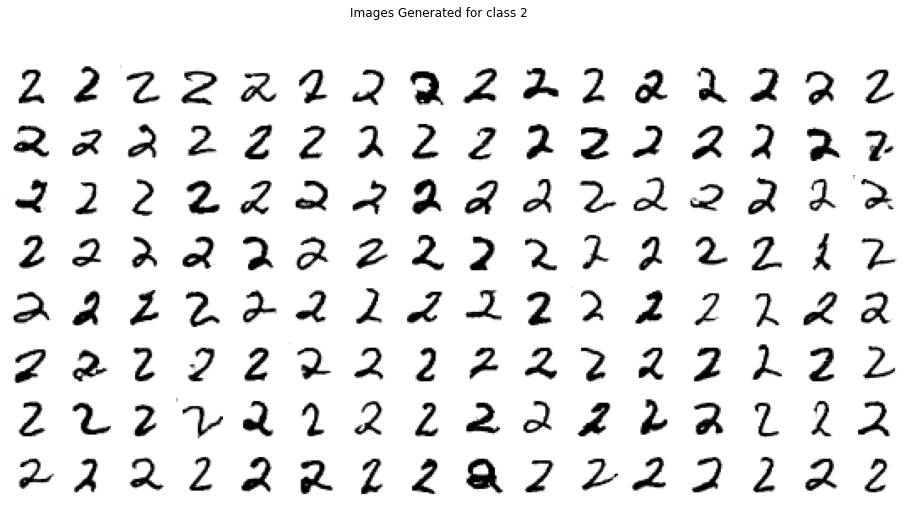

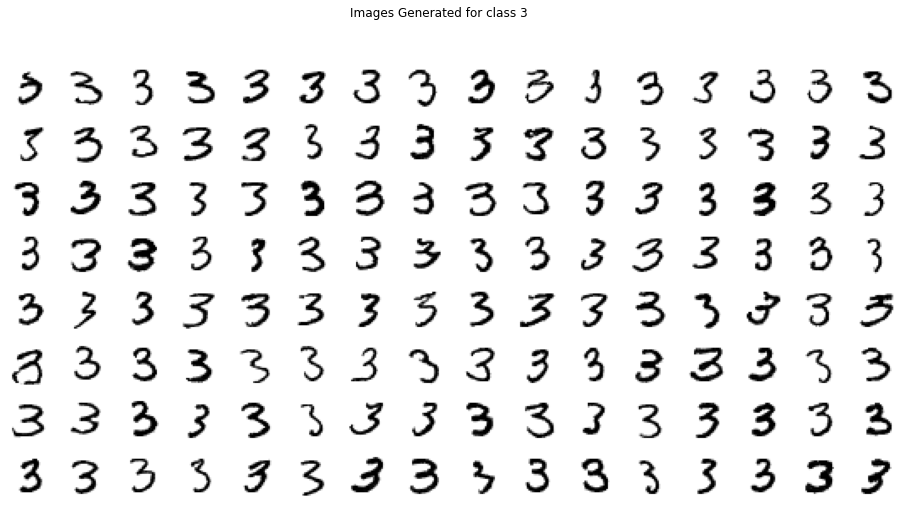

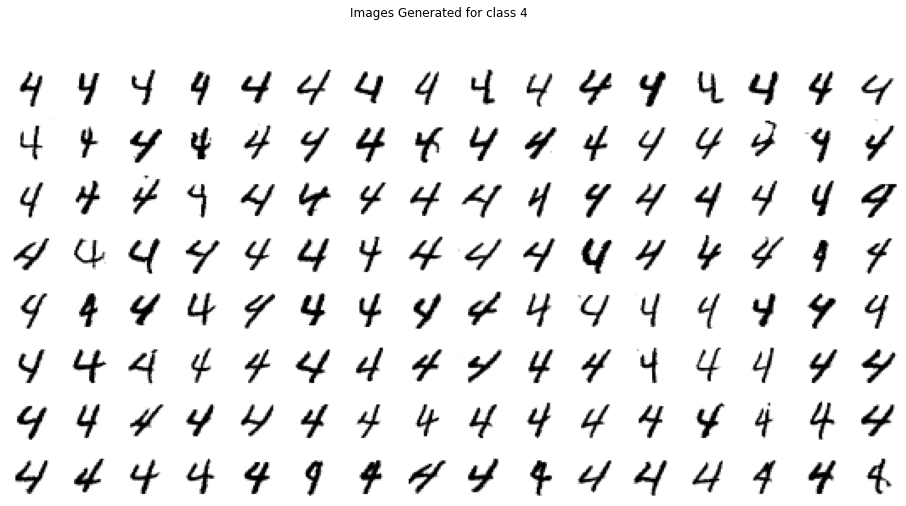

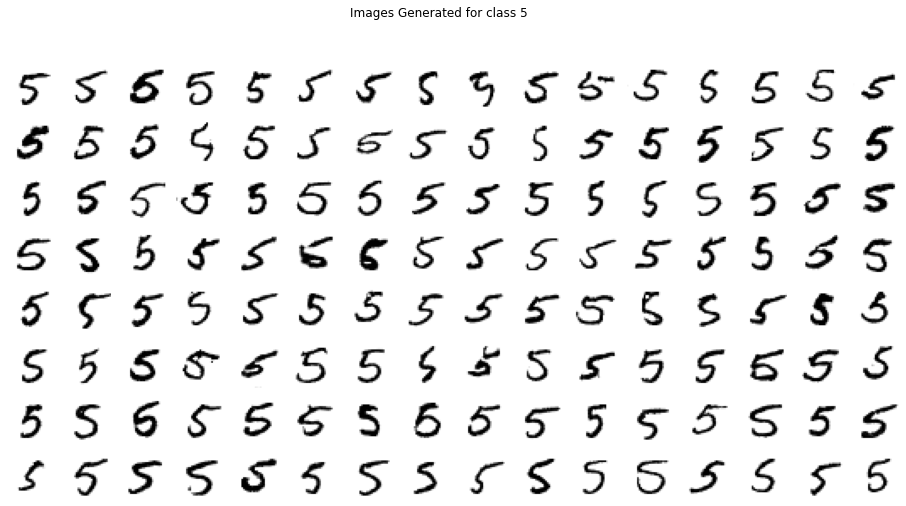

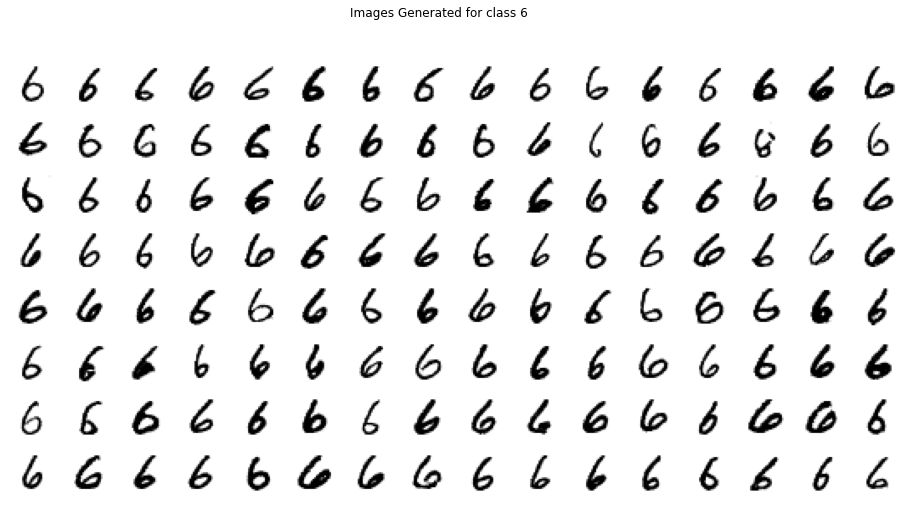

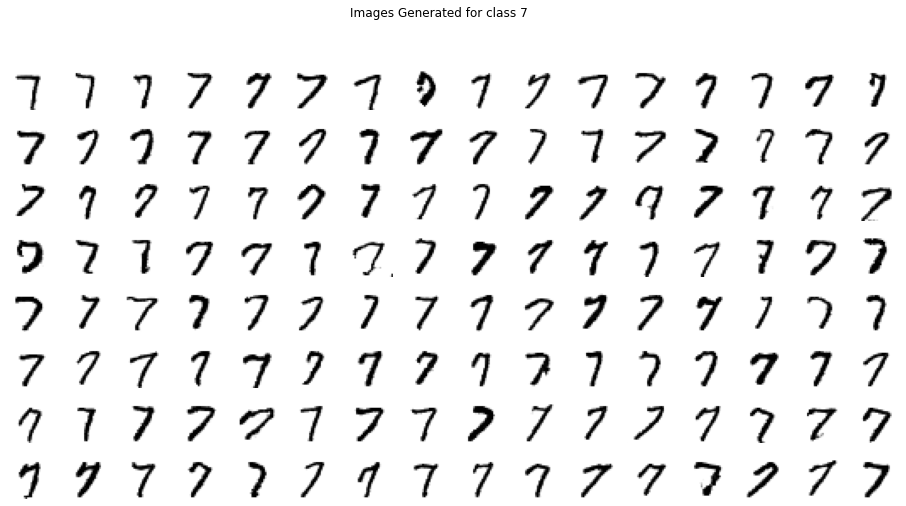

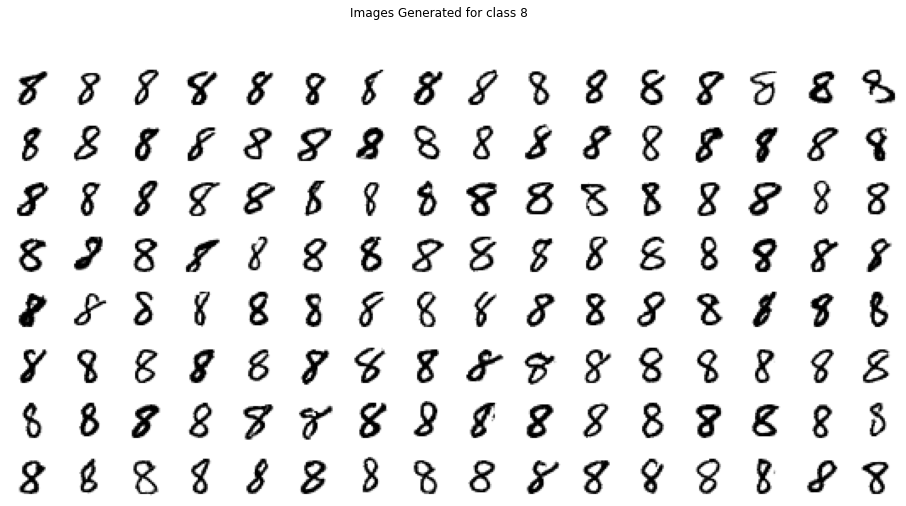

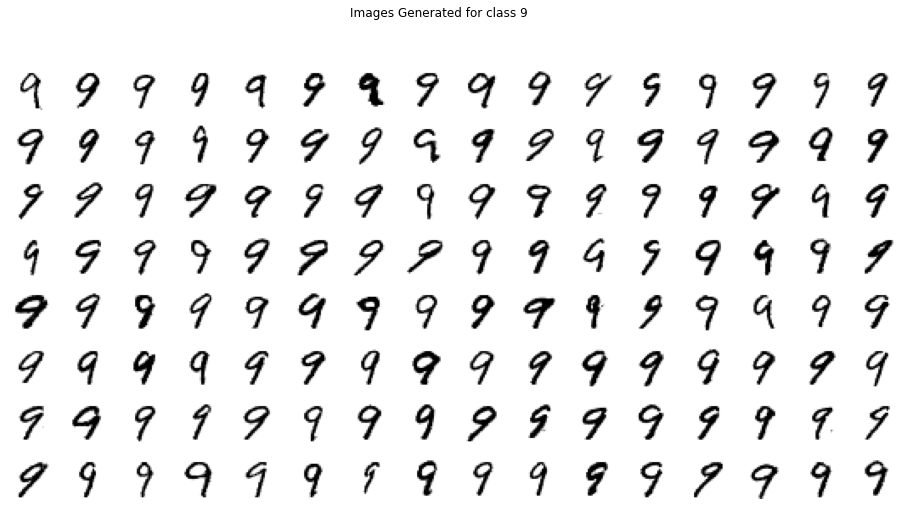

In [10]:
from scipy.linalg import sqrtm

def frechet_distance(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

evaluator = keras.models.Sequential(keras.models.load_model('../input/mnist-net/mnist_net.h5').layers[:-1])
scores = []
generator = keras.models.load_model(f'MNIST-AUG-ConditionalGAN.h5')

for i in range(10):
    inp_vect = tf.concat(
        (tf.random.normal([128, CODINGS_SIZE]), keras.utils.to_categorical(np.ones((128, 1))*i, 10)), 
        axis=1
    )
    fake_images = generator(inp_vect)
    embeddings_real = evaluator(prepare_images(i))
    embeddings_fake = evaluator(fake_images)
    scores.append(frechet_distance(embeddings_real, embeddings_fake))
    plot_results(fake_images, 16, f'Images Generated for class {i}')                     
    plt.show()  

# Evaluation

In [11]:
pd.Series(scores, name="Frechet Distance")

0     40.770621
1    116.782816
2     16.549531
3      8.752094
4     19.319004
5     14.881373
6     22.127629
7     30.545006
8     15.396234
9     20.056981
Name: Frechet Distance, dtype: float64